In [17]:
!pip install numpy scipy yfinance matplotlib --quiet

import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # optional if saving to Drive


Mounted at /content/drive


In [18]:
import sys, os
# If you've cloned your repo in /content, adjust the path accordingly
# Example if you `git clone`:
!git clone https://github.com/EkantheswarB/financial-math-stochastic-pricing.git
# sys.path.append("/content/financial-math-stochastic-pricing/")

sys.path.append("/content")  # if you upload 'models' next to this notebook

from models.black_scholes import black_scholes_price
from models.greeks import delta, gamma, vega, theta, rho
from models.data_loader import get_spx_options, get_spx_spot, get_risk_free_rate


fatal: destination path 'financial-math-stochastic-pricing' already exists and is not an empty directory.


In [19]:
import os
FIG_DIR = "/content/financial-math-stochastic-pricing/paper/figures"
os.makedirs(FIG_DIR, exist_ok=True)

def save_figure(fig, filename):
    path = os.path.join(FIG_DIR, filename)
    fig.savefig(path, dpi=300, bbox_inches="tight")
    print("Saved:", path)


In [20]:
S, K, T, r, sigma = 4500, 4500, 30/365, 0.045, 0.20
print("Call:", black_scholes_price(S,K,T,r,sigma,'call'))
print("Put :", black_scholes_price(S,K,T,r,sigma,'put'))
print("Delta(call):", delta(S,K,T,r,sigma,'call'))
print("Gamma:", gamma(S,K,T,r,sigma))


Call: 111.25194041314444
Put : 94.63884658020106
Delta(call): 0.5371175752016983
Gamma: 0.0015394592447497833


In [21]:
calls, puts = get_spx_options(nearest=True)
spot = get_spx_spot()
r = get_risk_free_rate()

expiry_str = calls["expiry"].iloc[0]
print("Expiry:", expiry_str)
print("Spot (SPX):", spot, "Risk-free (annual):", r)
calls.head()


Expiry: 2025-10-20
Spot (SPX): 6664.009765625 Risk-free (annual): 0.03832000017166138


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,option_type,expiry
0,SPXW251020C02800000,2025-10-14 13:02:57+00:00,2800.0,3796.41,3860.0,3884.1,0.00000,0.000000,1.0,3,4.336186,True,REGULAR,USD,call,2025-10-20
1,SPXW251020C03000000,2025-09-23 00:57:39+00:00,3000.0,3698.50,3660.1,3684.1,0.00000,0.000000,NaN,1,4.020025,True,REGULAR,USD,call,2025-10-20
2,SPXW251020C04400000,2025-10-14 13:59:36+00:00,4400.0,2190.77,2272.6,2274.1,0.00000,0.000000,1.0,6,2.283085,True,REGULAR,USD,call,2025-10-20
3,SPXW251020C04800000,2025-10-17 14:47:46+00:00,4800.0,1831.71,1860.0,1884.3,-7.97998,-0.433768,2.0,1,1.819581,True,REGULAR,USD,call,2025-10-20
4,SPXW251020C05300000,2025-10-17 14:34:49+00:00,5300.0,1334.94,1371.2,1375.3,-67.01001,-4.779772,20.0,19,1.365421,True,REGULAR,USD,call,2025-10-20


In [22]:
import pandas as pd
import numpy as np

df = calls.copy()
# Clean numeric columns
for c in ["strike", "lastPrice", "impliedVolatility"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Compute time to maturity in years
import datetime as dt
expiry_dt = pd.to_datetime(expiry_str)
now = pd.Timestamp.utcnow().tz_localize(None)
T = max((expiry_dt - now).days, 1) / 365.0  # min 1 day

# Filter near-the-money strikes
df = df.dropna(subset=["strike","lastPrice","impliedVolatility"])
df_ntm = df.loc[(df["strike"] > spot*0.95) & (df["strike"] < spot*1.05)].copy()

# Black–Scholes price using market IV (for consistency)
def bs_with_iv(row):
    return black_scholes_price(spot, row["strike"], T, r, row["impliedVolatility"], "call")

df_ntm["bs_price"] = df_ntm.apply(bs_with_iv, axis=1)
df_ntm["pricing_error"] = df_ntm["lastPrice"] - df_ntm["bs_price"]

df_ntm_sorted = df_ntm.sort_values("strike")
df_ntm_sorted[["strike","lastPrice","bs_price","pricing_error"]].head(10)


,strike,lastPrice,bs_price,pricing_error
16,6340.0,342.45,325.166444,17.283556
17,6350.0,300.49,315.183211,-14.693211
18,6360.0,341.87,305.221372,36.648628
19,6375.0,292.37,290.387741,1.982259
20,6400.0,237.27,265.305573,-28.035573
21,6410.0,241.98,255.354655,-13.374655
22,6425.0,233.01,240.382961,-7.372961
23,6440.0,218.20,225.469504,-7.269504
24,6450.0,216.94,215.518384,1.421616
25,6460.0,176.70,205.696930,-28.996930


Saved: /content/financial-math-stochastic-pricing/paper/figures/pricing_error_vs_strike.png


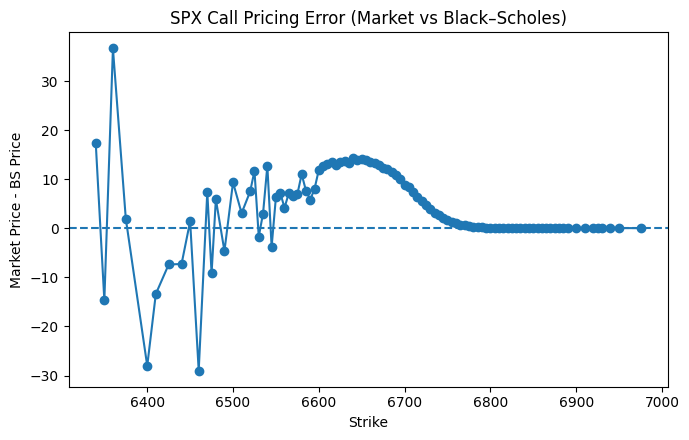

In [24]:
fig = plt.figure(figsize=(7,4.5))
plt.plot(df_ntm_sorted["strike"], df_ntm_sorted["pricing_error"], marker='o')
plt.axhline(0, linestyle='--')
plt.xlabel("Strike")
plt.ylabel("Market Price - BS Price")
plt.title("SPX Call Pricing Error (Market vs Black–Scholes)")
plt.tight_layout()
save_figure(fig, "pricing_error_vs_strike.png")
plt.show()


Saved: /content/financial-math-stochastic-pricing/paper/figures/Delta_vs_strike.png


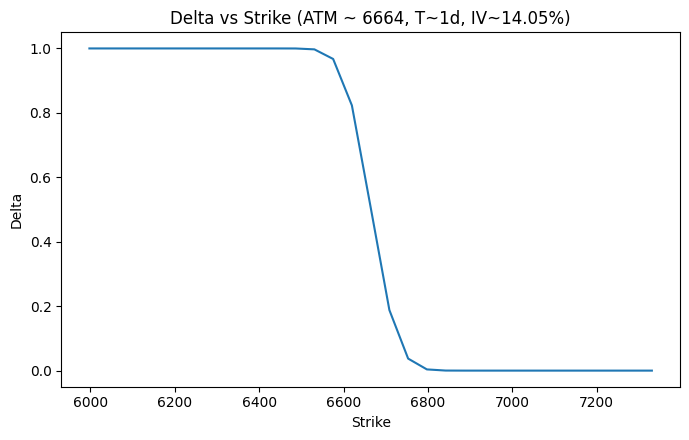

Saved: /content/financial-math-stochastic-pricing/paper/figures/Gamma_vs_strike.png


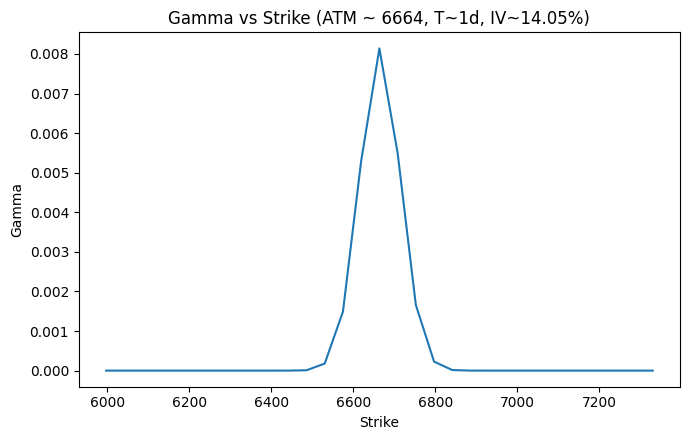

Saved: /content/financial-math-stochastic-pricing/paper/figures/Vega_vs_strike.png


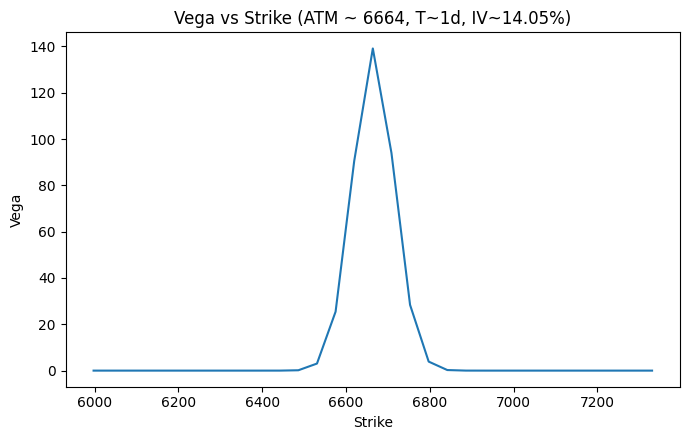

In [25]:
strikes = np.linspace(spot*0.9, spot*1.1, 31)
iv = df_ntm["impliedVolatility"].median() if not df_ntm.empty else 0.20
greeks = {
    "Delta": [delta(spot,k,T,r,iv,'call') for k in strikes],
    "Gamma": [gamma(spot,k,T,r,iv) for k in strikes],
    "Vega":  [vega(spot,k,T,r,iv) for k in strikes],
}

for name, series in greeks.items():
    fig = plt.figure(figsize=(7,4.5))
    plt.plot(strikes, series)
    plt.xlabel("Strike")
    plt.ylabel(name)
    plt.title(f"{name} vs Strike (ATM ~ {spot:.0f}, T~{T*365:.0f}d, IV~{iv:.2%})")
    plt.tight_layout()
    save_figure(fig, f"{name}_vs_strike.png")
    plt.show()
